## Лабораторная 5: логистическая регрессия. ROC. AUC. One-hot encoding

## 1
Рассмотрим данные медицинской страховой фирмы. На основе характеристик пациентов `Members.csv` (возраст, пол) и данных о получении медицинского обслуживания в предыдущем году `Claims_Y1.csv` (медицинское учреждение, врач, тип проблемы, количество дней госпитализации, дата, и др. ) нужно предсказать факт госпитализации хотя бы на 1 день в следующем году `DaysInHospital_Y2.csv`.

In [1]:
import pandas as pd

from sklearn import *

%matplotlib inline
import matplotlib.pyplot as plt

Прочтите данные, в качестве параметра index_col используйте `MemberID`. 

* данные из таблицы 'DaysInHospital_Y2.csv' в переменную `days2`
* данные из таблицы 'Members.csv' в переменную `m`
* данные из таблицы 'Claims_Y1.csv' в переменную `claims`

In [2]:
# место для кода
days2 = pd.read_csv('DaysInHospital_Y2.csv', delimiter=',', index_col='MemberID')
days2

,ClaimsTruncated,DaysInHospital
MemberID,,
98324177,0,0
33899367,1,1
5481382,0,1
69908334,0,0
29951458,0,0
...,...,...
1702326,0,0
31530440,0,0
87102780,0,0


In [3]:
m = pd.read_csv('Members.csv', delimiter=',', index_col='MemberID')
m

,AgeAtFirstClaim,Sex
MemberID,,
14723353,70-79,M
75706636,70-79,M
17320609,70-79,M
69690888,40-49,M
33004608,0-9,M
...,...,...
99711514,40-49,F
31690877,50-59,F
9519985,30-39,F


In [4]:
claims = pd.read_csv('Claims_Y1.csv', delimiter=',', index_col='MemberID')
claims

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
99829076,6721023.0,265273.0,91972.0,Y1,Rehabilitation,Office,162+,NaN,0- 1 month,TRAUMA,0,MED,0
54666321,9932074.0,35565.0,27294.0,Y1,Diagnostic Imaging,Office,29,NaN,0- 1 month,RESPR4,0,RAD,0
66951188,4699470.0,179509.0,75876.0,Y1,Diagnostic Imaging,Inpatient Hospital,51,NaN,0- 1 month,ROAMI,0,RAD,0
78859054,9121540.0,523791.0,21579.0,Y1,Emergency,Urgent Care,22,1 day,6- 7 months,HEART2,0,SDS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98535515,7638907.0,559727.0,83829.0,Y1,Emergency,Urgent Care,44,NaN,7- 8 months,TRAUMA,0,EM,0
1344508,4107701.0,164823.0,78718.0,Y1,Laboratory,Independent Lab,17,NaN,NaN,CATAST,0,SCS,0
73820095,1256697.0,789572.0,821.0,Y1,Surgery,Office,35,NaN,5- 6 months,MSC2a3,1-2,MED,0


## 2
Чтобы анонимизировать данные организатор указал приблизительную информацию о пациентах, например в столбце возраст указаны возрастные группы: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. Преобразуем строковые признаки в количественные и заменим пропущенные значения:

In [5]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: s.split('-')[0] if s!='80+' else '80')
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s))

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

m.Sex = m.Sex.fillna(value='N')

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

d:\system.files\temp\ipykernel_2992\3847602414.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)


In [6]:
claims['DSFS'].unique()

array(['8- 9 months', '0- 1 month', '6- 7 months', '10-11 months',
       '4- 5 months', '5- 6 months', '1- 2 months', nan, '2- 3 months',
       '3- 4 months', '7- 8 months', '11-12 months', '9-10 months'],
      dtype=object)

In [7]:
len(claims['PCP'].unique())

1006

## 3
Сконструируем признаки по массиву случаев медицинского обслуживания: 
* `f_Charlson` — максимальный индекс коморбидности Чальсона по всем случаям для пациента (`CharlsonIndex` в таблице `claims`)
* `f_LengthOfStay` — суммарное количество дней госпитализации в прошлом году (`LengthOfStay` в таблице `claims`) 

*Функции, которые могут пригодиться при решении: `.groupby(['MemberID']), .max(), .sum()`* 

In [8]:
f_Charlson = claims['CharlsonIndex'].groupby(['MemberID']).max()  #место для кода
f_LengthOfStay = claims['LengthOfStay'].groupby(['MemberID']).sum()# место для кода

display(f_Charlson, f_LengthOfStay)

MemberID
210         0
3197        0
3889        1
4187        0
9063        0
           ..
99995554    0
99996214    0
99997485    0
99997895    0
99998627    1
Name: CharlsonIndex, Length: 76038, dtype: int64

MemberID
210         2
3197        0
3889        3
4187        0
9063        0
           ..
99995554    0
99996214    0
99997485    0
99997895    0
99998627    2
Name: LengthOfStay, Length: 76038, dtype: int64

## 4

Составим матрицу объектов признаков со столбцами: `f_Charlson`, `f_LengthOfStay`, возраст пациента, `ClaimsTruncated` (не оказалось ли случаев медицинского обслуживания слишком много):

*Функции, которые могут пригодиться при решении: `.join()`*

In [9]:
data = days2
data = data.join(f_Charlson)
data = data.join(f_LengthOfStay)
#data = data.join()

data_reset = data.copy()
#нужно для экспериментов в номере 7-8

# место для кода
data = data[ ['ClaimsTruncated', 'CharlsonIndex', 'LengthOfStay', 'DaysInHospital'] ]
data.head(5)

,ClaimsTruncated,CharlsonIndex,LengthOfStay,DaysInHospital
MemberID,,,,
98324177,0,0,0,0
33899367,1,0,0,1
5481382,0,0,0,1
69908334,0,0,0,0
29951458,0,0,0,0


## 5
Составим функцию, которая будет делить выборку на две части `dataTrain` и `dataTest`, обучать логистическую регрессию на `dataTrain`, применять к `dataTest`, строить кривую ошибок и считать под ней площадь:

In [10]:
def calcAUC(data):
    dataTrain, dataTest = model_selection.train_test_split(data, test_size=0.5, random_state=1)
    
    model = linear_model.LogisticRegression()
    model.fit( dataTrain.loc[:, dataTrain.columns != 'DaysInHospital'], dataTrain.DaysInHospital )
     #model.fit(X, Y)
    
    predictionProb = model.predict_proba( dataTest.loc[:, dataTest.columns != 'DaysInHospital'] )
     #model.predict_proba(_bility)(X)
    #print(predictionProb.shape)
    #print(predictionProb.argmax(axis=1))
    
   ##Meytics 
    fpr, tpr, _ = metrics.roc_curve(dataTest['DaysInHospital'], predictionProb[:,1])
     #Receiver Operating Characteristic (ROC)
     #fpr - false positive rate
     #tpr - true positive rate
    
   ##Plot
    plt.figure()
    #plt.axis('equal')
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend(['calc ROC', 'worst ROC (1:1)'])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()
    
    print(f"{'current' :9s} : {metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:,1])} ")
    
    return metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:,1])

## 6
Применим данную функцию к `data`:

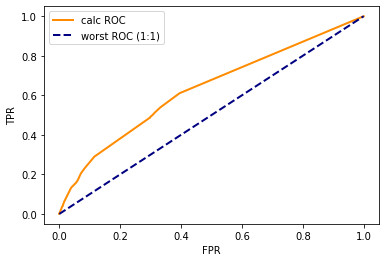

current   : 0.6307469087049324 


0.6307469087049324

In [11]:
calcAUC(data)

## 7
Логистическая регрессия принимает на вход только количественные признаки.

Добавим к нашим данным пол пациента, применив one hot encoding:

*Функции, которые могут пригодиться при решении: `pd.get_dummies(m.Sex, prefix='pol')`* 

In [12]:
pd.get_dummies(m.Sex, prefix='pol', dtype='int')

,pol_F,pol_M,pol_N
MemberID,,,
14723353,0,1,0
75706636,0,1,0
17320609,0,1,0
69690888,0,1,0
33004608,0,1,0
...,...,...,...
99711514,1,0,0
31690877,1,0,0
9519985,1,0,0


## 8
Попытайтесь применить  one hot encoding к уже существующим в `data2` признакам или составить новые признаки по массиву `claims`.

In [28]:
data.groupby(['CharlsonIndex']).count()

,ClaimsTruncated,LengthOfStay,DaysInHospital
CharlsonIndex,,,
0,51880,51880,51880
1,21353,21353,21353
3,2477,2477,2477
5,327,327,327


In [171]:
data=data_reset
data

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay
MemberID,,,,
98324177,0,0,0,0
33899367,1,1,0,0
5481382,0,1,0,0
69908334,0,0,0,0
29951458,0,0,0,0
...,...,...,...,...
1702326,0,0,0,0
31530440,0,0,0,0
87102780,0,0,0,0


In [172]:
#издевательства над data
data = data.join(pd.get_dummies(m.Sex, prefix='pol', dtype='int'))

data

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,pol_F,pol_M,pol_N
MemberID,,,,,,,
98324177,0,0,0,0,0,1,0
33899367,1,1,0,0,1,0,0
5481382,0,1,0,0,1,0,0
69908334,0,0,0,0,1,0,0
29951458,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
1702326,0,0,0,0,0,0,1
31530440,0,0,0,0,0,1,0
87102780,0,0,0,0,1,0,0


In [173]:
data = data.join(claims['PCP'].groupby(['MemberID']).count()) 
data = data.rename(columns={"PCP": "StaysNum"})
data

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,pol_F,pol_M,pol_N,StaysNum
MemberID,,,,,,,,
98324177,0,0,0,0,0,1,0,6
33899367,1,1,0,0,1,0,0,41
5481382,0,1,0,0,1,0,0,12
69908334,0,0,0,0,1,0,0,17
29951458,0,0,0,0,0,1,0,12
...,...,...,...,...,...,...,...,...
1702326,0,0,0,0,0,0,1,16
31530440,0,0,0,0,0,1,0,1
87102780,0,0,0,0,1,0,0,2


In [159]:
claims['PCP'] = claims['PCP'].fillna(value=0)
most_frequent_doctor = claims['PCP'].groupby(['MemberID']).agg(pd.Series.mode).to_frame()
most_frequent_doctor
#data

,PCP
MemberID,
210,37508
3197,47016
3889,37796
4187,45901
9063,78718
...,...
99995554,1303
99996214,13742
99997485,27585


In [160]:
most_frequent_doctor.isna().sum()

PCP    0
dtype: int64

In [167]:
#data = data.join(most_frequent_doctor)
#data

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,pol_F,pol_M,pol_N,StaysNum,PCP
MemberID,,,,,,,,,
98324177,0,0,0,0,0,1,0,6,58880
33899367,1,1,0,0,1,0,0,41,38724
5481382,0,1,0,0,1,0,0,12,75876
69908334,0,0,0,0,1,0,0,17,13281
29951458,0,0,0,0,0,1,0,12,39946
...,...,...,...,...,...,...,...,...,...
1702326,0,0,0,0,0,0,1,16,20363
31530440,0,0,0,0,0,1,0,1,52059
87102780,0,0,0,0,1,0,0,2,64416


In [165]:
claims.loc[4187, ["ProviderID", "Vendor", "PCP"]]
#data.loc[4187,:]

,ProviderID,Vendor,PCP
MemberID,,,
4187,4212539.0,1093.0,45901
4187,8883983.0,887998.0,45901
4187,8213434.0,756785.0,45901
4187,8883983.0,887998.0,45901


In [174]:
data.dtypes

ClaimsTruncated    int64
DaysInHospital     int64
CharlsonIndex      int64
LengthOfStay       int64
pol_F              int32
pol_M              int32
pol_N              int32
StaysNum           int64
dtype: object

Построившему матрицу объектов признаков, для которой логистическая регрессия работает с наилучшим качеством: +5 бонусных баллов.

## check

In [175]:
max_auc = 0.679323842376006
best_columns = ['ClaimsTruncated',
                  'DaysInHospital',
                  'CharlsonIndex',
                  'LengthOfStay',
                  'pol_F',
                  'pol_M',
                  'pol_N',
                  'StaysNum']
#area ander curve

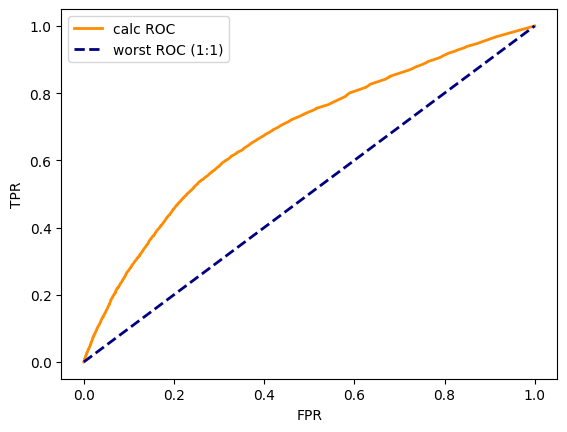

current   : 0.679323842376006 
max       : 0.679323842376006


In [176]:
cur_auc = calcAUC(data)

if cur_auc > max_auc:
    max_auc = cur_auc
    best_columns = list(data.columns)
    
print(f"{'max' :9s} : {max_auc}")

In [178]:
max_auc, list(best_columns)

(0.679323842376006,
 ['ClaimsTruncated',
  'DaysInHospital',
  'CharlsonIndex',
  'LengthOfStay',
  'pol_F',
  'pol_M',
  'pol_N',
  'StaysNum'])

In [179]:
data

,ClaimsTruncated,DaysInHospital,CharlsonIndex,LengthOfStay,pol_F,pol_M,pol_N,StaysNum
MemberID,,,,,,,,
98324177,0,0,0,0,0,1,0,6
33899367,1,1,0,0,1,0,0,41
5481382,0,1,0,0,1,0,0,12
69908334,0,0,0,0,1,0,0,17
29951458,0,0,0,0,0,1,0,12
...,...,...,...,...,...,...,...,...
1702326,0,0,0,0,0,0,1,16
31530440,0,0,0,0,0,1,0,1
87102780,0,0,0,0,1,0,0,2
